<a href="https://colab.research.google.com/github/moustafa-7/Car-GANs_project/blob/master/Keras_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Maximellerbach/Car-DCGAN-Keras.git

Cloning into 'Car-DCGAN-Keras'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (530/530), done.
remote: Compressing objects: 100% (529/529), done.
remote: Total 746 (delta 29), reused 479 (delta 1), pack-reused 216
Receiving objects: 100% (746/746), 95.41 MiB | 12.68 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [0]:
import os
os.chdir("Car-DCGAN-Keras")

In [0]:
%pycat generate.py

In [0]:
os.mkdir('my_imgs')

In [0]:
%%writefile generate.py

from keras.models import load_model
import cv2
from tqdm import tqdm
import numpy as np
from glob import glob
import time


gen = load_model('vroum//vroumgen.h5')
dis = load_model('vroum//vroumdis.h5')


while(1):

    rand_noise = np.random.normal(0, 1, (1, 100))
    pred = gen.predict(rand_noise)
    confidence = dis.predict(pred)

    gen_img = (0.5 * pred[0] + 0.5)*255

    cv2.imwrite("my_imgs/"+str(time.time())+'_'+str(confidence[0][0])+'.png', gen_img)

Overwriting generate.py


In [0]:
%%writefile gan.py

import os
import time
from glob import glob

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import (Activation, BatchNormalization, Dense, Dropout,
                          Embedding, Flatten, Input, Reshape, ZeroPadding2D,
                          multiply)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import (AveragePooling2D, Conv2D,
                                        Conv2DTranspose, MaxPooling2D,
                                        UpSampling2D, ZeroPadding2D)
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from tqdm import tqdm


class DCGAN():

    def __init__(self):

        self.img_rows = 100
        self.img_cols = 150
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100


        optimizer = Adam(0.0001, 0.5)

        '''
        # uncomment to build discriminator, generator
        
        self.discriminator = self.create_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
        self.generator = self.create_generator()
        
        '''

        # uncomment to load discriminator, generator
        self.discriminator = load_model('vroum//vroumdis.h5')
        self.discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
        self.generator = load_model('vroum//vroumgen.h5')
        
        # the combined model take an image as input and output validity from 0 to 1
        # note that in the combined model, the discriminator is not trainable
        self.discriminator.trainable = False
        
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        valid = self.discriminator(img)

        self.combined = Model(z, valid) 
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def create_generator(self):

        model = Sequential()

        model.add(Dense(6 * 9 * 256, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((6, 9, 256)))

        model.add(Conv2D(256, kernel_size=(3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())
        
        model.add(Conv2D(128, kernel_size=(3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        
        model.add(UpSampling2D())

        model.add(ZeroPadding2D(padding = ((0,1),(0,1))))

        model.add(Conv2D(64, kernel_size=(3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())

        model.add(ZeroPadding2D(padding = (0,(1,0))))

        model.add(Conv2D(32, kernel_size=(3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(UpSampling2D())

        model.add(Conv2D(16, kernel_size=(3,3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(self.channels, kernel_size=(1,1), padding="same"))
        model.add(Activation("tanh"))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        model.summary()

        return Model(noise, img)




    def create_discriminator(self):
        
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(AveragePooling2D())
        model.add(Dropout(0.2))

        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(AveragePooling2D())
        model.add(Dropout(0.2))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)

        model.summary()

        return Model(img, validity)

    

    def train(self, batch_size=128, save_interval=50, save_img_interval=50):
        
        #get dataset
        X_train = self.load_dataset('car_img//*')

        # ones = label for real images
        # zeros = label for fake images
        ones = np.ones((batch_size, 1)) 
        zeros = np.zeros((batch_size, 1))

        # create some noise to track AI's progression
        self.noise_pred = np.random.normal(0, 1, (1, self.latent_dim))

        epoch = 0
        while(1):
            epoch+=1

            # Select a random batch of images in dataset
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)   

            # Train the discriminator with generated images and real images
            d_loss_r = self.discriminator.train_on_batch(imgs, ones)
            d_loss_f = self.discriminator.train_on_batch(gen_imgs, zeros)
            d_loss = np.add(d_loss_r , d_loss_f)*0.5

            # Trains the generator to fool the discriminator
            g_loss = self.combined.train_on_batch(noise, ones)

            #print loss and accuracy of both trains
            print ("%d D loss: %f, acc.: %.2f%% G loss: %f" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            

            if epoch % save_img_interval == 0:
                self.save_imgs(epoch)
            
            if epoch % save_interval == 0:

                #self.discriminator.save('gan\\vroum\\vroumdis_'+str(epoch)+'.h5')
                #self.generator.save('gan\\vroum\\vroumgen_'+str(epoch)+'.h5')

                self.discriminator.save('vroum//vroumdis.h5')
                self.generator.save('vroum//vroumgen.h5')

    def save_imgs(self, epoch):

        gen_img = self.generator.predict(self.noise_pred)
        confidence = self.discriminator.predict(gen_img)

        # Rescale image to 0 - 255
        gen_img = (0.5 * gen_img + 0.5)*255

        cv2.imwrite('car//%d_%f.png'%(epoch, confidence), gen_img[0])


    def load_dataset(self,path):

        try:
            # try to load existing X_train
            X_train = np.load('X_train.npy')
            print('loaded dataset')

        except:
            # else, build X_train and save it
            X_train = []
            dos = glob(path)

            for i in tqdm(dos):
                img = cv2.imread(i)
                img = cv2.resize(img,(self.img_cols, self.img_rows))

                X_train.append(img)

            cv2.destroyAllWindows()
            X_train = np.array(X_train)

            # Rescale dataset to -1 - 1
            X_train = X_train / 127.5 - 1

            np.save('X_train.npy',X_train)
            print('created dataset')
            
        return X_train


if __name__ == '__main__':

    cgan = DCGAN()
    cgan.train(batch_size=8, save_interval=5000, save_img_interval=25)

Overwriting gan.py


In [0]:
!python generate.py

Using TensorFlow backend.
W0827 01:28:08.131962 139672555734912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 01:28:08.166800 139672555734912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 01:28:08.233519 139672555734912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 01:28:08.233807 139672555734912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0827

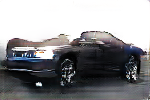

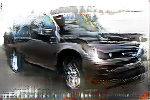

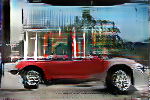

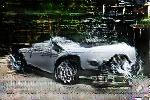

In [10]:
from IPython.display import Image, display
display(Image('gen/1554321001.7964919_1.0.png'))
display(Image('gen/1554321001.8373823_1.0.png'))
display(Image('gen/1554321001.866305_1.0.png'))
display(Image('gen/1554321001.9351218_1.0.png'))
